In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

In [3]:
##Configuration

#config the connector jar file
spark = (SparkSession.builder.appName("SimpleSparkJob").master("spark://34.142.194.212:7077")
         .config("spark.jars", "/opt/spark/jars/gcs-connector-latest-hadoop2.jar")
         .config("spark.executor.memory", "2G")  #excutor excute only 2G
        .config("spark.driver.memory","4G") 
        .config("spark.executor.cores","3") #Cluster use only 3 cores to excute
        .config("spark.python.worker.memory","1G") # each worker use 1G to excute
        .config("spark.driver.maxResultSize","3G") #Maximum size of result is 3G
        .config("spark.kryoserializer.buffer.max","1024M")
         .getOrCreate())
#config the credential to identify the google cloud hadoop file 
spark.conf.set("google.cloud.auth.service.account.json.keyfile","/opt/spark/lucky-wall-393304-2a6a3df38253.json")
spark._jsc.hadoopConfiguration().set('fs.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem')
spark._jsc.hadoopConfiguration().set('fs.gs.auth.service.account.enable', 'true')

## Connect to the file in Google Bucket with Spark


# spark.show()

# spark.stop # Ending spark job


23/12/08 14:16:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/08 14:16:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## EDA

In [4]:
path=f"gs://it4043e-it5384/it4043e/it4043e_group7_problem1/final_preprocess"
tweet_final = spark.read \
    .format("parquet") \
    .option("inferSchema", "true") \
    .option("escape", "\"") \
    .option("multiline", "true") \
    .option("wholeFile", "true") \
.load(path)
tweet_final.show()

+--------------------+--------------------+-------------------+------------------+--------------------+------+-------------+--------------------+--------------------+----------+--------+
|            username|          tweet_text| datetime_timestamp|          tweet_id|     discussion_link|images|video_preview|       user_location|    user_description|      date|    time|
+--------------------+--------------------+-------------------+------------------+--------------------+------+-------------+--------------------+--------------------+----------+--------+
|                   0|$QNT #QNT Communi...|2021-08-05 15:56:26|158836031181224018|https://twitter.c...|    []|           []|                 USA|#BTC $ETH \n$QNT ...|2021-08-05|15:56:26|
|                   0|@QNTMami Safe to ...|2021-11-26 17:14:11|146609917543097691|https://twitter.c...|    []|           []|                 USA|$QNT $HTR $LCX $C...|2021-11-26|17:14:11|
|             0001337|@JackFarley96 Its...|2022-01-22 07:48:02|15

In [5]:
df = tweet_final.toPandas()

In [6]:
df.head()

,username,tweet_text,datetime_timestamp,tweet_id,discussion_link,images,video_preview,user_location,user_description,date,time
0,0,$QNT #QNT Community #OVN is coming \n\n2.0.1 \...,2021-08-05 15:56:26,158836031181224018,https://twitter.com/0/status/158836031181224018,[],[],USA,#BTC $ETH \n$QNT $CHR $HTR $LCX $RSR $ALGO\nNo...,2021-08-05,15:56:26
1,0,@QNTMami Safe to say?\n\nIn 2017 #BTC had a 20...,2021-11-26 17:14:11,146609917543097691,https://twitter.com/0/status/146609917543097691,[],[],USA,$QNT $HTR $LCX $CHR $ETH #BTC $RSR\nNot Financ...,2021-11-26,17:14:11
2,0001337,@JackFarley96 Its so much more than high beta....,2022-01-22 07:48:02,159052628733145591,https://twitter.com/0001337/status/15905262873...,[],[],SHA256,,2022-01-22,07:48:02
3,0012A,@BtcPadre Cantillion afflicted everything \n\n...,2021-12-30 12:09:52,164257367032476738,https://twitter.com/0012A/status/1642573670324...,[],[],#POW♻️,#POW = e your own ank = Type 1 civilization | ...,2021-12-30,12:09:52
4,0012A,@CerebralWisdom @akkaufman Just re read your c...,2021-11-26 07:23:44,107679374667622220,https://twitter.com/0012A/status/1076793746676...,[],[],#POW♻️,#POW = e your own ank = Type 1 civilization | ...,2021-11-26,07:23:44


In [7]:
df.shape

(2354815, 11)

In [8]:
df.columns

Index(['username', 'tweet_text', 'datetime_timestamp', 'tweet_id',
       'discussion_link', 'images', 'video_preview', 'user_location',
       'user_description', 'date', 'time'],
      dtype='object')

In [9]:
df.describe()

,tweet_id
count,2.354815e+06
mean,1.555812e+17
std,9.030869e+16
min,1.000000e+17
25%,1.251213e+17
50%,1.502086e+17
75%,1.753396e+17
max,1.723853e+18


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354815 entries, 0 to 2354814
Data columns (total 11 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   username            object
 1   tweet_text          object
 2   datetime_timestamp  object
 3   tweet_id            int64 
 4   discussion_link     object
 5   images              object
 6   video_preview       object
 7   user_location       object
 8   user_description    object
 9   date                object
 10  time                object
dtypes: int64(1), object(10)
memory usage: 197.6+ MB


In [11]:
df.isna().sum()

username                 6798
tweet_text                  1
datetime_timestamp          0
tweet_id                    0
discussion_link            63
images                      0
video_preview               0
user_location         1240033
user_description       368521
date                        0
time                        3
dtype: int64

### Split datetime

In [13]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.dropna(subset = ['date','time'])

In [14]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

/tmp/ipykernel_955165/3808089464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year
/tmp/ipykernel_955165/3808089464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date'].dt.month
/tmp/ipykernel_955165/3808089464.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354775 entries, 0 to 2354814
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   username            object        
 1   tweet_text          object        
 2   datetime_timestamp  object        
 3   tweet_id            int64         
 4   discussion_link     object        
 5   images              object        
 6   video_preview       object        
 7   user_location       object        
 8   user_description    object        
 9   date                datetime64[ns]
 10  time                datetime64[ns]
 11  year                int64         
 12  month               int64         
 13  day                 int64         
dtypes: datetime64[ns](2), int64(4), object(8)
memory usage: 269.5+ MB


In [16]:
df21 = df[df['year'] == 2021]
df21.head()

,username,tweet_text,datetime_timestamp,tweet_id,discussion_link,images,video_preview,user_location,user_description,date,time,year,month,day
0,0,$QNT #QNT Community #OVN is coming \n\n2.0.1 \...,2021-08-05 15:56:26,158836031181224018,https://twitter.com/0/status/158836031181224018,[],[],USA,#BTC $ETH \n$QNT $CHR $HTR $LCX $RSR $ALGO\nNo...,2021-08-05,2023-12-08 15:56:26,2021,8,5
1,0,@QNTMami Safe to say?\n\nIn 2017 #BTC had a 20...,2021-11-26 17:14:11,146609917543097691,https://twitter.com/0/status/146609917543097691,[],[],USA,$QNT $HTR $LCX $CHR $ETH #BTC $RSR\nNot Financ...,2021-11-26,2023-12-08 17:14:11,2021,11,26
3,0012A,@BtcPadre Cantillion afflicted everything \n\n...,2021-12-30 12:09:52,164257367032476738,https://twitter.com/0012A/status/1642573670324...,[],[],#POW♻️,#POW = e your own ank = Type 1 civilization | ...,2021-12-30,2023-12-08 12:09:52,2021,12,30
4,0012A,@CerebralWisdom @akkaufman Just re read your c...,2021-11-26 07:23:44,107679374667622220,https://twitter.com/0012A/status/1076793746676...,[],[],#POW♻️,#POW = e your own ank = Type 1 civilization | ...,2021-11-26,2023-12-08 07:23:44,2021,11,26
5,0012A,@TomerStrolight @disclosetv #bitcoin legal ten...,2021-12-17 22:13:08,163719306481582444,https://twitter.com/0012A/status/1637193064815...,[],[],#POW♻️,#POW = e your own ank = Type 1 civilization | ...,2021-12-17,2023-12-08 22:13:08,2021,12,17


In [31]:
df22 = df[df['year'] == 2022]
df22.head()

,username,tweet_text,datetime_timestamp,tweet_id,discussion_link,images,video_preview,user_location,user_description,date,time,year,month,day
2,0001337,@JackFarley96 Its so much more than high beta....,2022-01-22 07:48:02,159052628733145591,https://twitter.com/0001337/status/15905262873...,[],[],SHA256,,2022-01-22,2023-12-08 07:48:02,2022,1,22
18,0x146,"@Dennis_Porter_ He was right though, the bigge...",2022-05-12 15:55:14,191954009951088378,https://twitter.com/0x146/status/1919540099510...,[],[],"Scotland, United Kingdom","pleb. Recently called a ""Financially illiterat...",2022-05-12,2023-12-08 15:55:14,2022,5,12
19,0x146,Are you zooming out anon? On panic selling you...,2022-09-13 12:49:27,119482467444981304,https://twitter.com/0x146/status/1194824674449...,[],[],"Scotland, United Kingdom","#bitcoinpleb. Recently called a ""Financially i...",2022-09-13,2023-12-08 12:49:27,2022,9,13
20,0x146,What do my fellow #bitcoin plebs recognise more?,2022-10-12 07:54:03,111047491791989911,https://twitter.com/0x146/status/1110474917919...,[],[],"Scotland, United Kingdom","#bitcoinpleb. Recently called a ""Financially i...",2022-10-12,2023-12-08 07:54:03,2022,10,12
21,0x146gfy,Average 3.5k #bitcoin leaving exchanges every ...,2022-11-13 23:20:47,165486003459207226,https://twitter.com/0x146gfy/status/1654860034...,[],[],"Scotland, United Kingdom","#bitcoinpleb, Proud member of the class of 21....",2022-11-13,2023-12-08 23:20:47,2022,11,13


In [18]:
df23 = df[df['year'] == 2023]
df23.head()

,username,tweet_text,datetime_timestamp,tweet_id,discussion_link,images,video_preview,user_location,user_description,date,time,year,month,day
16,0rang3enlightenedmultichainevangelist,BTC/XAF\n\nSorry macron\n\n#Bitcoin https://t....,2023-01-07 21:54:44,183048844114611260,https://twitter.com/0rang3enlightenedmultichai...,[],[],Totalitarian super state,13%\n\nShitposting from a Nokia 3310 via star...,2023-01-07,2023-12-08 21:54:44,2023,1,7
45,0xNy0m0tusernameorg,"@BonkCoin_ I like this project, from the very ...",2023-01-07 04:15:01,183164342294794425,https://twitter.com/0xNy0m0tusernameorg/status...,[],[],"Bandung Wetan, Indonesia",0xabu,2023-01-07,2023-12-08 04:15:01,2023,1,7
75,0xUpdate,Weekly #Crypto performances. \n1. #Bitcoin-2.0...,2023-01-09 12:35:06,102502893726117551,https://twitter.com/0xUpdate/status/1025028937...,[],[],Cryptocurrency & NFTs,"Follow 0x Update To Get All The Crypto Update,...",2023-01-09,2023-12-08 12:35:06,2023,1,9
84,0xYannn,While Im only about to start DCA some coins fr...,2023-01-09 15:42:21,113254008423879802,https://twitter.com/0xYannn/status/11325400842...,[],[],"Melbourne, Victoria","Former banker, cyclical investor, defi player,...",2023-01-09,2023-12-08 15:42:21,2023,1,9
103,100XCryptoPromoter,new big project join it #RealYield #ICO #CRYP...,2023-01-09 15:30:43,120306674631087584,https://twitter.com/100XCryptoPromoter/status/...,[],[],Waziristan,#BlueMove and #MOVErs,2023-01-09,2023-12-08 15:30:43,2023,1,9


## Visualization

### Tweet/hour

In [21]:
from tqdm import tqdm

In [22]:
def get_hour(text):
  hour_re = int(text.split(':')[0])
  return hour_re

In [23]:
df4 = list(df['time'])

count_tmp = {}

for x in tqdm(df4):
  a = x.hour
  if(a in count_tmp):
    count_tmp[a] += 1
  else:
    count_tmp[a] = 1

count_tmp = dict(sorted(count_tmp.items(), key=lambda x: int(x[0])))

print('\n',count_tmp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2354775/2354775 [00:01<00:00, 1940373.01it/s]


 {0: 53010, 1: 48612, 2: 48832, 3: 48423, 4: 49369, 5: 53432, 6: 58815, 7: 70532, 8: 75994, 9: 80708, 10: 84192, 11: 95937, 12: 108504, 13: 125787, 14: 137244, 15: 140983, 16: 144044, 17: 145555, 18: 149642, 19: 142489, 20: 140085, 21: 128220, 22: 116210, 23: 108156}


In [24]:
df4 = list(df['time'])

count_tmp = {}

for x in tqdm(df4):
  a = x.hour
  if(a in count_tmp):
    count_tmp[a] += 1
  else:
    count_tmp[a] = 1

count_tmp = dict(sorted(count_tmp.items(), key=lambda x: int(x[0])))

print('\n',count_tmp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2354775/2354775 [00:01<00:00, 1980123.90it/s]


 {0: 53010, 1: 48612, 2: 48832, 3: 48423, 4: 49369, 5: 53432, 6: 58815, 7: 70532, 8: 75994, 9: 80708, 10: 84192, 11: 95937, 12: 108504, 13: 125787, 14: 137244, 15: 140983, 16: 144044, 17: 145555, 18: 149642, 19: 142489, 20: 140085, 21: 128220, 22: 116210, 23: 108156}


### Tweet / day of month

In [25]:
def count_tweet(df):
    count_tmp = {}

    for x in tqdm(df):
        if(x in count_tmp):
          count_tmp[x] += 1
        else:
          count_tmp[x] = 1

    count_tmp = dict(sorted(count_tmp.items(), key=lambda x: int(x[0])))

    return count_tmp

In [26]:
df2 = list(df['day'])
count_tmp2 = count_tweet(df2)
print(count_tmp2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2354775/2354775 [00:00<00:00, 2935616.86it/s]

{1: 49447, 2: 55561, 3: 42465, 4: 32162, 5: 39597, 6: 40974, 7: 41728, 8: 33411, 9: 83967, 10: 58890, 11: 60823, 12: 105260, 13: 97019, 14: 99883, 15: 131081, 16: 95704, 17: 76712, 18: 128106, 19: 139643, 20: 87279, 21: 128632, 22: 136292, 23: 93434, 24: 76985, 25: 77851, 26: 91829, 27: 38293, 28: 50124, 29: 71059, 30: 66730, 31: 23834}


In [27]:
df212 = list(df21['day'])
count_tmp212 = count_tweet(df212)
print(count_tmp212)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1007571/1007571 [00:00<00:00, 2740958.45it/s]

{1: 297, 2: 9047, 3: 13063, 4: 25624, 5: 39509, 6: 34603, 7: 10467, 8: 22037, 9: 31132, 10: 15725, 11: 14257, 12: 23153, 13: 1387, 14: 9063, 15: 17749, 16: 17056, 17: 35796, 18: 66064, 19: 94969, 20: 58656, 21: 69574, 22: 70080, 23: 63847, 24: 34907, 25: 49892, 26: 64878, 27: 20555, 28: 30324, 29: 31825, 30: 31862, 31: 173}


In [32]:
df222 = list(df22['day'])
count_tmp222 = count_tweet(df222)
print(count_tmp222)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1314380/1314380 [00:00<00:00, 2726366.47it/s]

{1: 49148, 2: 46512, 3: 29401, 4: 6533, 6: 3980, 7: 19721, 8: 9116, 9: 38054, 10: 42930, 11: 46199, 12: 80988, 13: 95630, 14: 90820, 15: 113331, 16: 78646, 17: 40914, 18: 62041, 19: 44671, 20: 28621, 21: 59057, 22: 66210, 23: 29585, 24: 42075, 25: 27957, 26: 26948, 27: 17736, 28: 19798, 29: 39233, 30: 34866, 31: 23659}


In [33]:
df232 = list(df23['day'])
count_tmp232 = count_tweet(df232)
print(count_tmp232)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32824/32824 [00:00<00:00, 2078377.96it/s]

{1: 2, 2: 2, 3: 1, 4: 5, 5: 88, 6: 2391, 7: 11540, 8: 2258, 9: 14781, 10: 235, 11: 367, 12: 1119, 13: 2, 15: 1, 16: 2, 17: 2, 18: 1, 19: 3, 20: 2, 21: 1, 22: 2, 23: 2, 24: 3, 25: 2, 26: 3, 27: 2, 28: 2, 29: 1, 30: 2, 31: 2}


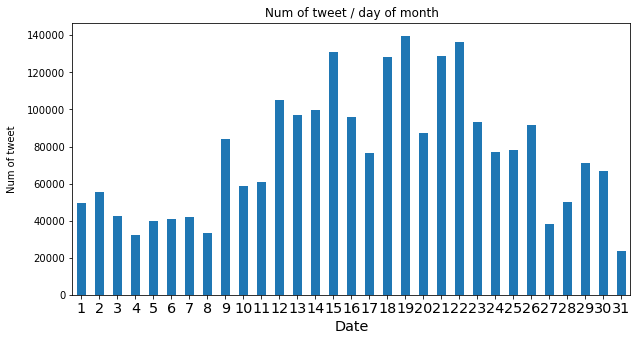

In [34]:
plt.figure(figsize=(10,5))
pd.Series(count_tmp2).plot(kind = 'bar')
plt.xticks(rotation=0, fontsize = 'x-large')
plt.xlabel('Date',fontsize = 'x-large')
plt.xlabel('Date')
plt.ylabel('Num of tweet', labelpad=10 )
plt.title('Num of tweet / day of month')
plt.show()

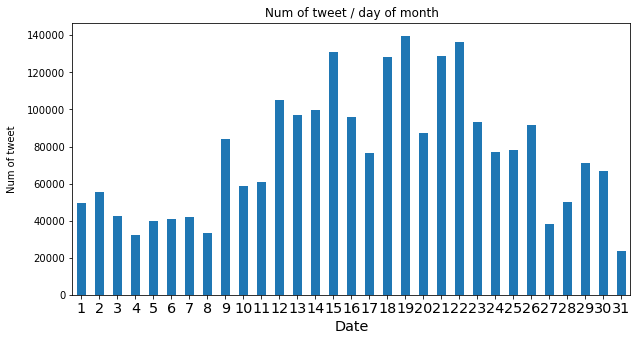

In [35]:
plt.figure(figsize=(10,5))
pd.Series(count_tmp2).plot(kind = 'bar')
plt.xticks(rotation=0, fontsize = 'x-large')
plt.xlabel('Date',fontsize = 'x-large')
plt.xlabel('Date')
plt.ylabel('Num of tweet', labelpad=10 )
plt.title('Num of tweet / day of month')
plt.show()

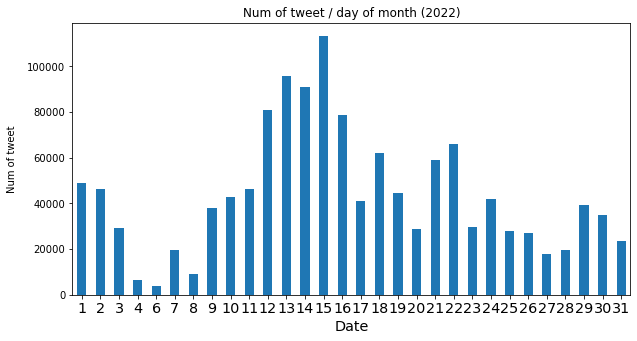

In [36]:
plt.figure(figsize=(10,5))
pd.Series(count_tmp222).plot(kind = 'bar')
plt.xticks(rotation=0, fontsize = 'x-large')
plt.xlabel('Date',fontsize = 'x-large')
plt.xlabel('Date')
plt.ylabel('Num of tweet', labelpad=10 )
plt.title('Num of tweet / day of month (2022)')
plt.show()

### tweet / date of year

In [37]:
df['day-month'] = df['day'].astype(str) + '-' + df['month'].astype(str)

In [38]:
from datetime import datetime

In [39]:
df4 = list(df['day-month'])
count_tmp3 = {}
for x in tqdm(df4):
  if(x in count_tmp3):
    count_tmp3[x] += 1
  else:
    count_tmp3[x] = 1
count_tmp3 = dict(sorted(count_tmp3.items(), key=lambda x: datetime.strptime(x[0], "%d-%m")))
print(count_tmp3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2354775/2354775 [00:01<00:00, 2066019.68it/s]

{'1-1': 90, '2-1': 87, '3-1': 86, '4-1': 92, '5-1': 86, '6-1': 2335, '7-1': 11477, '8-1': 2177, '9-1': 14692, '10-1': 87, '11-1': 5920, '12-1': 21307, '13-1': 21579, '14-1': 15083, '15-1': 90, '16-1': 92, '17-1': 89, '18-1': 91, '19-1': 1969, '20-1': 11200, '21-1': 17970, '22-1': 35865, '23-1': 85, '24-1': 90, '25-1': 91, '26-1': 87, '27-1': 86, '28-1': 90, '29-1': 91, '30-1': 91, '31-1': 88, '1-2': 83, '2-2': 66, '3-2': 92, '4-2': 92, '5-2': 959, '6-2': 1740, '7-2': 1624, '8-2': 2883, '9-2': 14995, '10-2': 1862, '11-2': 90, '12-2': 90, '13-2': 1209, '14-2': 4766, '15-2': 6882, '16-2': 1832, '17-2': 9310, '18-2': 10461, '19-2': 2349, '20-2': 91, '21-2': 83, '22-2': 1909, '23-2': 3, '24-2': 93, '25-2': 90, '26-2': 86, '27-2': 87, '28-2': 907, '1-3': 85, '2-3': 4238, '3-3': 88, '4-3': 88, '5-3': 87, '6-3': 4039, '7-3': 11978, '8-3': 2797, '9-3': 7935, '10-3': 16601, '11-3': 189, '12-3': 1974, '13-3': 88, '14-3': 1862, '15-3': 15833, '16-3': 21646, '17-3': 11671, '18-3': 10553, '19-3': 84

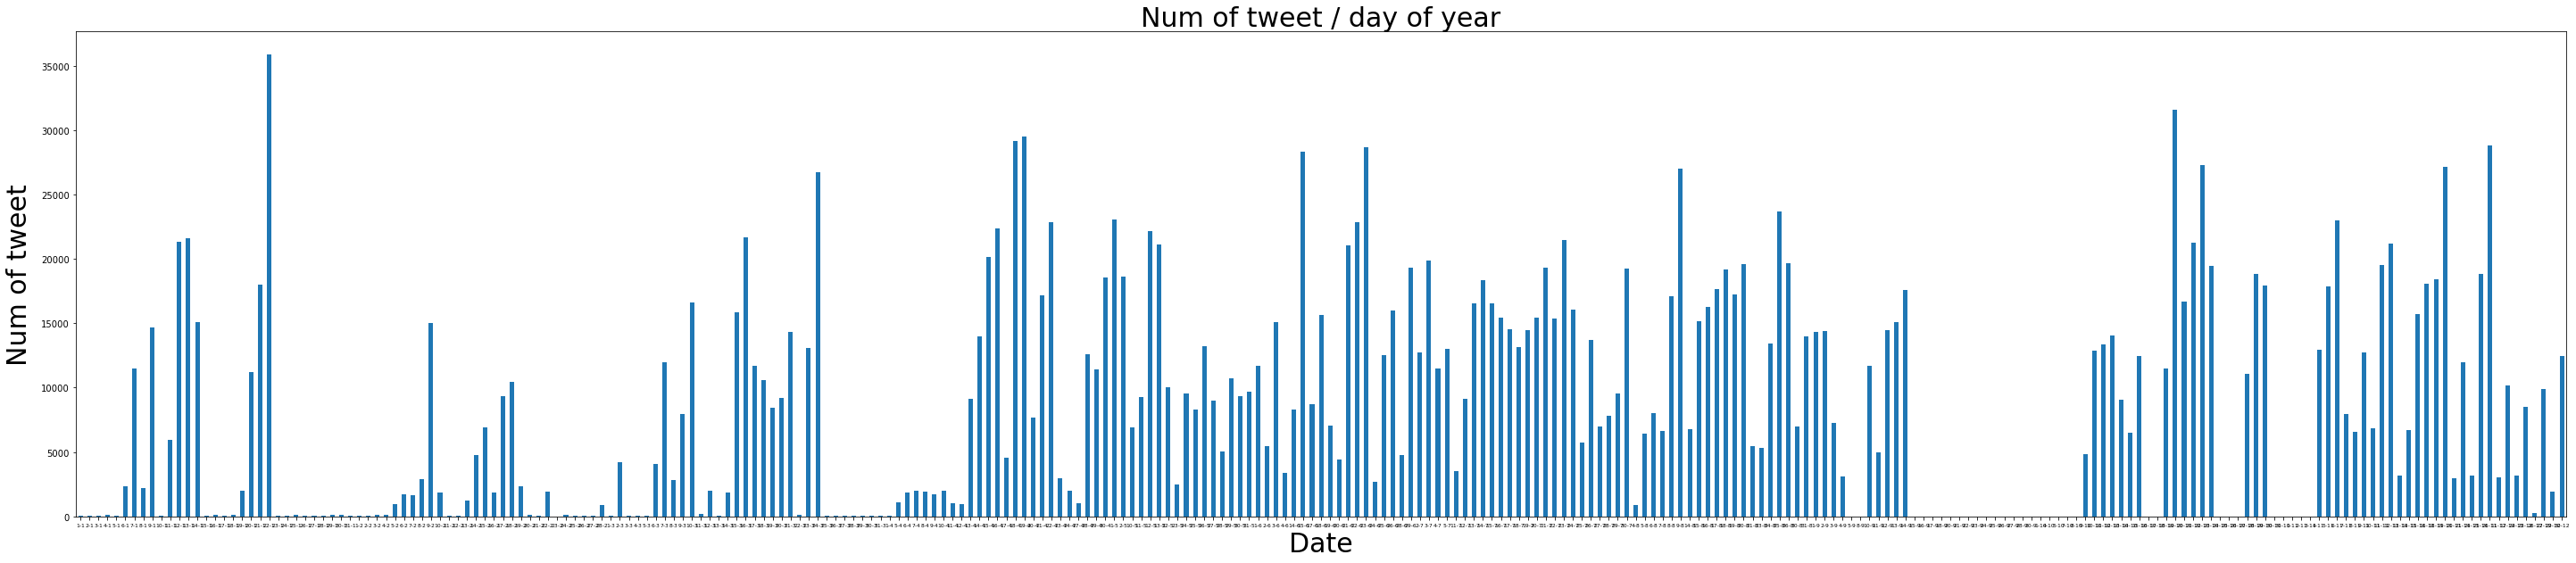

In [40]:
plt.figure(figsize=(50,10))
pd.Series(count_tmp3).plot(kind = 'bar')
plt.xticks(rotation=0, fontsize = '6')
plt.xlabel('Date',fontsize = '30')
plt.xlabel('Date')
plt.ylabel('Num of tweet', labelpad=10, fontsize = '30' )
plt.title('Num of tweet / day of year', fontsize = '30')
plt.show()

### tweet / month

In [41]:
df5 = list(df['month'])
count_tmp4 = count_tweet(df5)
print(count_tmp4)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2354775/2354775 [00:00<00:00, 2880316.35it/s]

{1: 163263, 2: 64734, 3: 184220, 4: 237633, 5: 188619, 6: 235853, 7: 329458, 8: 266325, 9: 102924, 10: 248761, 11: 283588, 12: 49397}


In [42]:
df215 = list(df21['month'])
count_tmp214 = count_tweet(df215)

df225 = list(df22['month'])
count_tmp224 = count_tweet(df225)

df235 = list(df23['month'])
count_tmp234 = count_tweet(df235)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32824/32824 [00:00<00:00, 2388139.16it/s]


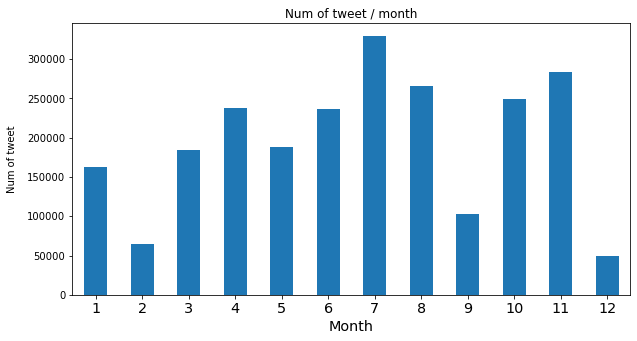

In [43]:
plt.figure(figsize=(10,5))
pd.Series(count_tmp4).plot(kind = 'bar')
plt.xticks(rotation=0, fontsize = 'x-large')
plt.xlabel('Month',fontsize = 'x-large')
plt.ylabel('Num of tweet', labelpad=10 )
plt.title('Num of tweet / month')
plt.show()

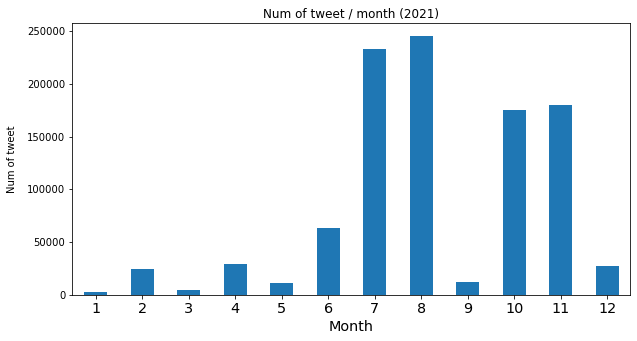

In [44]:
plt.figure(figsize=(10,5))
pd.Series(count_tmp214).plot(kind = 'bar')
plt.xticks(rotation=0, fontsize = 'x-large')
plt.xlabel('Month',fontsize = 'x-large')
plt.ylabel('Num of tweet', labelpad=10 )
plt.title('Num of tweet / month (2021)')
plt.show()

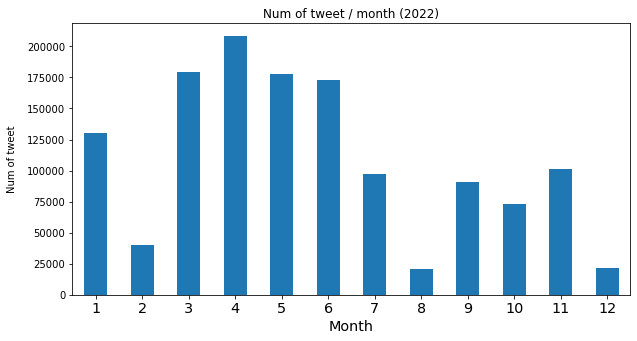

In [45]:
plt.figure(figsize=(10,5))
pd.Series(count_tmp224).plot(kind = 'bar')
plt.xticks(rotation=0, fontsize = 'x-large')
plt.xlabel('Month',fontsize = 'x-large')
plt.ylabel('Num of tweet', labelpad=10 )
plt.title('Num of tweet / month (2022)')
plt.show()